<a href="https://colab.research.google.com/github/Prateek2134/Plant-Diseases-Detection/blob/main/Plant_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import confusion_matrix

#for fast and memory efficient iterations
import itertools
from sklearn.metrics import classification_report

#to copy the content of the source file to the destination file or directory
import shutil

# to Visualations
import matplotlib.pyplot as plt
%matplotlib inline

# To Avoid The Warnings
import warnings
warnings.filterwarnings('ignore')

# Advanced Library to enhance the Image processing
import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize

In [11]:
# Creating the Ratio For Image:- ht,wt,image channel(bgr)
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3


In [13]:
#Source Directory(Our Data)
os.listdir('/content/drive/MyDrive/Plant dataset/rice_leaf_diseases')

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [15]:
bacterial_leaf_blight_list = os.listdir('/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Bacterial leaf blight')
brown_spot_list = os.listdir('/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Brown spot')
leaf_smut_list = os.listdir('/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Leaf smut')

print(len(bacterial_leaf_blight_list))
print(len(brown_spot_list))
print(len(leaf_smut_list))
print('Successfully Created....!')

40
40
40
Successfully Created....!


In [16]:
df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'


df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'


df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'



df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=50)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=50)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=50)
# Sample 5 validation images from each class
#We tried with taking diff no.of samples(7,8,10) and random_state(101,70,37,88,etc),
#we got the best values for accuracy when n=5,random_ste=50

print(len(df_bacterial_leaf_blight_val))
print(len(df_brown_spot_val))
print(len(df_leaf_smut_val))

5
5
5


In [17]:
# get a list of val images
val_list = list(df_bacterial_leaf_blight_val['image'])
# filter out the val images
df_bacterial_leaf_blight_train =df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin

In [18]:
# get a list of val images
val_list = list(df_brown_spot_val['image'])
# filter out the val images
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin

In [19]:
# get a list of val images
val_list = list(df_leaf_smut_val['image'])
# filter out the val images
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin


print(len(df_bacterial_leaf_blight_train))
print(len(df_brown_spot_train))
print(len(df_leaf_smut_train))

35
35
35


In [20]:
df_data = pd.concat([ df_bacterial_leaf_blight,df_brown_spot,df_leaf_smut],
                    axis=0).reset_index(drop=True)

df_train = pd.concat([df_bacterial_leaf_blight_train,df_brown_spot_train,df_leaf_smut_train],
                     axis=0).reset_index(drop=True)

df_val = pd.concat([df_bacterial_leaf_blight_val,df_brown_spot_val,df_leaf_smut_val],
                   axis=0).reset_index(drop=True)

In [21]:
#shuffle() is being used for shuffling the batch_sized chunks.It has no effect on steps_per_epoch when it is not NULL.
df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print("Actual Data :- ",df_data.shape)
print("Training Data: -",df_train.shape)
print("Validation Data :- ",df_val.shape)

Actual Data :-  (120, 2)
Training Data: - (105, 2)
Validation Data :-  (15, 2)


In [22]:
pd.DataFrame(df_data['target'].value_counts())

,target
leaf_smut,40
bacterial_leaf_blight,40
brown_spot,40


In [23]:
pd.DataFrame(df_train['target'].value_counts())

,target
brown_spot,35
bacterial_leaf_blight,35
leaf_smut,35


In [24]:
pd.DataFrame(df_val['target'].value_counts())

,target
bacterial_leaf_blight,5
brown_spot,5
leaf_smut,5


In [25]:
val_len = len(df_val)
train_len = len(df_train)

df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)


# create the dummy variables

df_combined = pd.get_dummies(df_combined, columns=['target']).reset_index(drop=True)

# separate the train and val sets

val_len = len(df_val)
train_len = len(df_train)

df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(105, 4)
(15, 4)


In [26]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0396.JPG,1,0,0
1,DSC_0332.JPG,0,1,0
2,DSC_0109.jpg,0,1,0
3,DSC_0406.JPG,1,0,0
4,DSC_0507.jpg,0,0,1


In [27]:
df_train.head()


,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0100.jpg,0,1,0
16,DSC_0389.JPG,1,0,0
17,DSC_0508.jpg,0,0,1
18,DSC_0382.JPG,1,0,0
19,DSC_0307.JPG,0,1,0


In [28]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0396.JPG,1,0,0
1,DSC_0332.JPG,0,1,0
2,DSC_0109.jpg,0,1,0
3,DSC_0406.JPG,1,0,0
4,DSC_0507.jpg,0,0,1


In [29]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)
df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

In [30]:
# Create a new directory
image_dir = 'image_dir'
os.mkdir(image_dir)

In [32]:
  # Transfer the bacterial_leaf_blight images
  for fname in bacterial_leaf_blight_list:

      path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Bacterial leaf blight'

      # source path to image
      src = os.path.join(path, fname)
      # destination path to image
      dst = os.path.join(image_dir, fname)
      # copy the image from the source to the destination
      shutil.copyfile(src, dst)

In [33]:
# Transfer the brown_spot images
for fname in brown_spot_list:

    path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Brown spot'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [34]:
# Transfer the leaf_smut images
for fname in leaf_smut_list:

    path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Leaf smut'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [35]:
len(os.listdir('image_dir'))

120

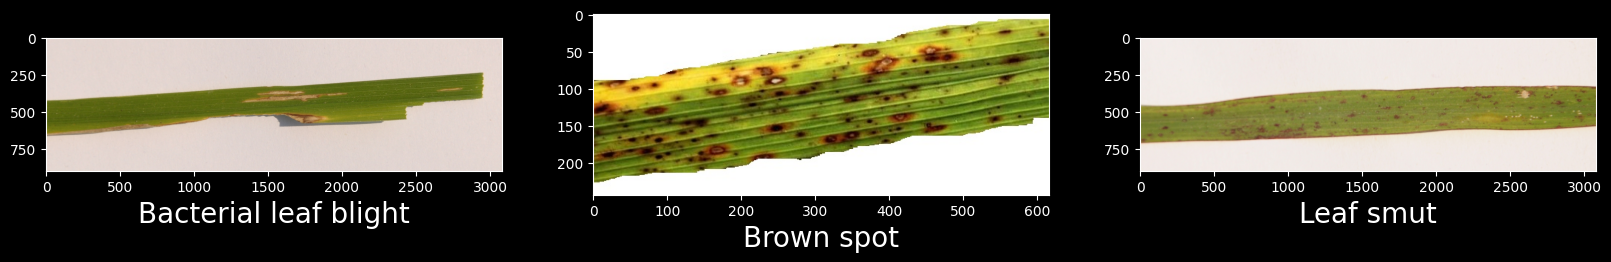

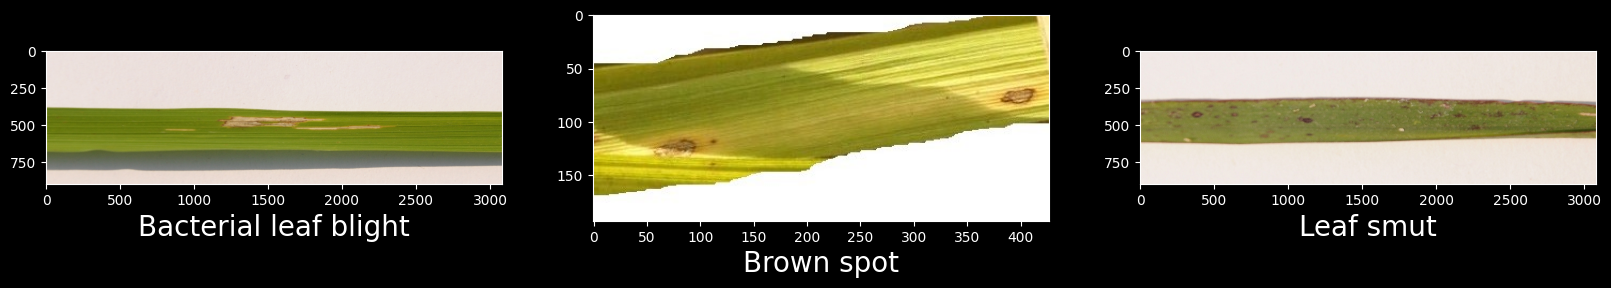

In [38]:
# set up the canvas for the subplots
plt.style.use('dark_background')
plt.figure(figsize=(20,20))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0365.JPG'
path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0101.jpg'
path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)


# Image 3
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0312.JPG'
path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

#-----------------------------------------------------------------------------------------------------#

# set up the canvas for the subplots
plt.figure(figsize=(20,20))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0378.JPG'
path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0112.jpg'
path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 3
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0319.jpg'
path = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)


plt.show()


In [39]:
def augment_image(augmentation, image):

    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    return image_matrix

In [40]:
aug_types = albu.Compose([
            albu.HorizontalFlip(),              #rotating the input by 180 degrees horizontally
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),            #rotating the input by 180 degrees vertically
                ], p=0.8),                      #p=probability of applying the transform.
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),             #Also used to adjust the degree of contrast within the image for better view.
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),  #Transformation of pixels
                albu.GridDistortion(),                     #image warping technique which makes changes to the grid structure
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5), # This distort certain elemnts in the image.
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])

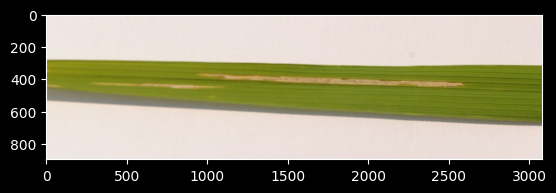

In [41]:
# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)
plt.show()

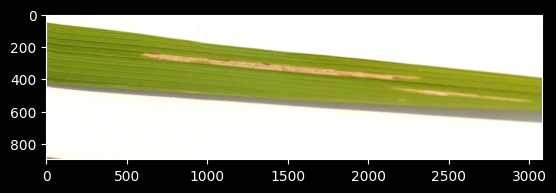

In [42]:
# The image will be different each time this cell is run.
aug_image = augment_image(aug_types, image)
plt.imshow(aug_image)
plt.show()

In [43]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0100.jpg,0,1,0
16,DSC_0389.JPG,1,0,0
17,DSC_0508.jpg,0,0,1
18,DSC_0382.JPG,1,0,0
19,DSC_0307.JPG,0,1,0


In [44]:
def train_generator(batch_size=8):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))


            # Create X_train
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                 # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)

                # insert the image into X_train
                X_train[i] = aug_image




            # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train)

            # Normalize the images
            X_train = X_train/255



            yield X_train, y_train

In [45]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [46]:
def train_generator(batch_size=8):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)


            # Create X_train
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train)

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size


            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)

                # insert the image into X_train
                X_train[i] = aug_image



            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train


In [47]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)
(8, 224, 224, 3)
(8, 3)


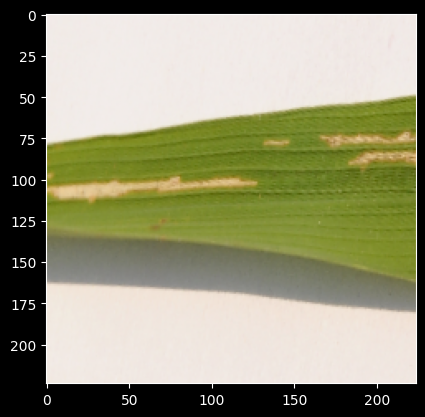

In [48]:
# Print an image in X_train
image = X_train[1,:,:,:]
plt.imshow(image)
plt.show()

In [49]:
def val_generator(batch_size=5):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)


           # Create X_val
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image



            # Create y_val
            # ===============

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val)

            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [50]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


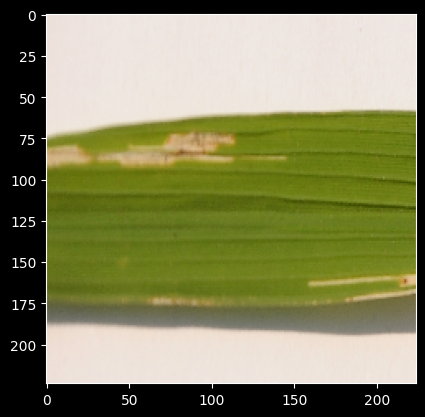

In [51]:
# print an image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)
plt.show()

In [52]:
def test_generator(batch_size=1):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)



             # Create X_test
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image



            # Normalize the images
            X_test = X_test/255

            yield X_test

In [53]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


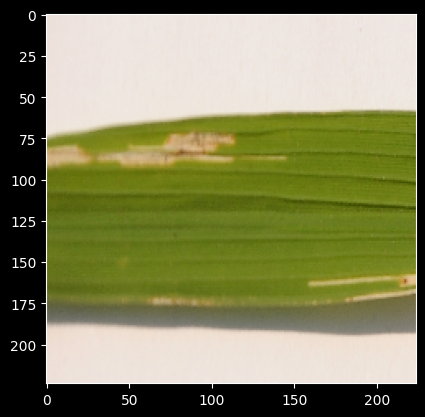

In [54]:
# print an image from X_test
image = X_test[0,:,:,:]
plt.imshow(image)
plt.show()

In [55]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint,LearningRateScheduler)
from keras.preprocessing import image

In [56]:
from tensorflow.keras.applications.mobilenet import MobileNet
model = MobileNet(weights='imagenet')
x = model.output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

In [57]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [58]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "leaf.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,verbose=1, mode='min')

callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=15,
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Epoch 1/15
14/14 [==============================] - ETA: 0s - loss: 1.0804 - accuracy: 0.5714
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to leaf.h5
14/14 [==============================] - 35s 2s/step - loss: 1.0804 - accuracy: 0.5714 - val_loss: 1.1009 - val_accuracy: 0.3333
Epoch 2/15
14/14 [==============================] - ETA: 0s - loss: 1.0748 - accuracy: 0.6095
Epoch 2: val_accuracy improved from 0.33333 to 0.40000, saving model to leaf.h5
14/14 [==============================] - 20s 1s/step - loss: 1.0748 - accuracy: 0.6095 - val_loss: 1.0923 - val_accuracy: 0.4000
Epoch 3/15
14/14 [==============================] - ETA: 0s - loss: 1.0573 - accuracy: 0.7048
Epoch 3: val_accuracy improved from 0.40000 to 0.46667, saving model to leaf.h5
14/14 [==============================] - 22s 2s/step - loss: 1.0573 - accuracy: 0.7048 - val_loss: 1.0768 - val_accuracy: 0.4667
Epoch 4/15
14/14 [==============================] - ETA: 0s - loss: 1.0545 - accuracy: 0.6667


In [59]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [60]:
model.load_weights('leaf.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc =model.evaluate_generator(val_gen,steps=len(df_val))
# Val_gen = 15 steps

print('val_loss:', val_loss)
print('val_acc:', val_acc)


val_loss: 1.0796324014663696
val_acc: 0.5333333611488342


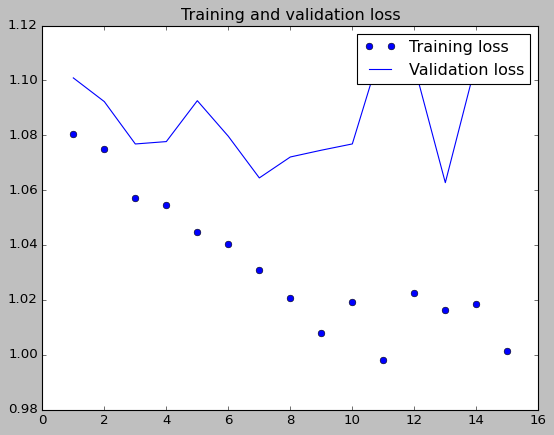

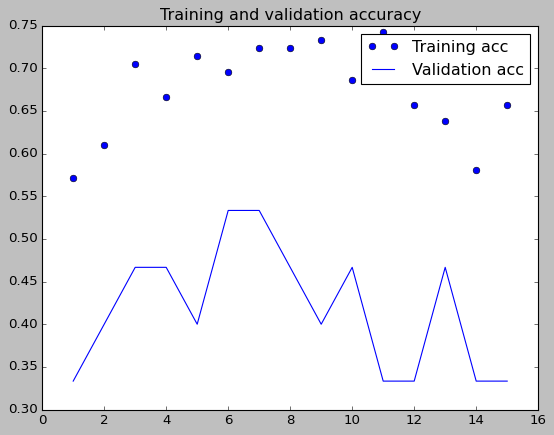

<Figure size 640x480 with 0 Axes>

In [61]:
# display the loss and accuracy curves

plt.style.use('classic')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

In [62]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

15/15 [==============================] - 3s 71ms/step


In [63]:
y_pred = np.argmax(preds, axis=1)

y_pred

array([1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 0, 1, 0])

In [64]:
cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true)

y_true = np.argmax(y_true, axis=1)

y_true

array([0, 1, 1, 0, 2, 2, 2, 1, 1, 2, 0, 2, 0, 1, 0])

In [65]:
print(y_pred)
print(y_true)

[1 1 1 2 1 2 1 1 2 1 0 1 0 1 0]
[0 1 1 0 2 2 2 1 1 2 0 2 0 1 0]


In [66]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

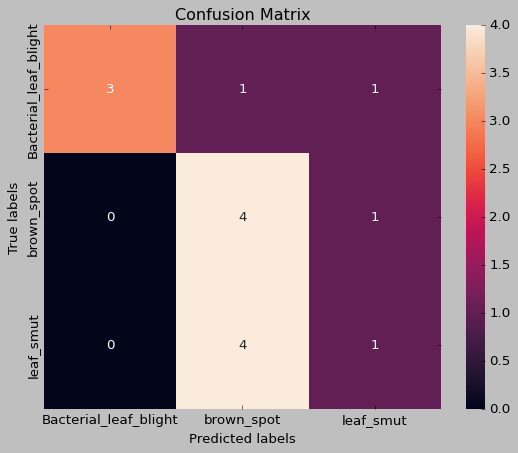

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g',ax=ax,xticklabels=['Bacterial_leaf_blight', 'brown_spot', 'leaf_smut'],yticklabels=['Bacterial_leaf_blight', 'brown_spot', 'leaf_smut']);
#annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set(title='Confusion Matrix',xlabel='Predicted labels',ylabel='True labels');

In [68]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.60      0.75         5
           brown_spot       0.44      0.80      0.57         5
            leaf_smut       0.33      0.20      0.25         5

             accuracy                           0.53        15
            macro avg       0.59      0.53      0.52        15
         weighted avg       0.59      0.53      0.52        15



1/1 [==============================] - 0s 92ms/step
Source Label : /content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG
Predicted Label: target_bacterial_leaf_blight


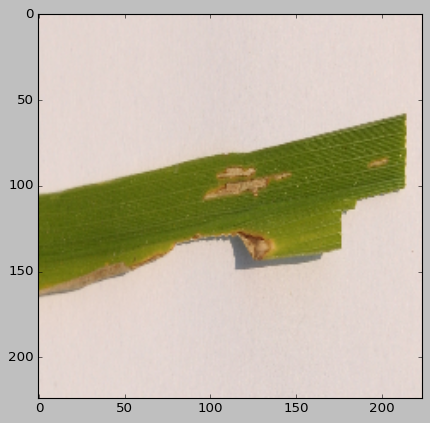

In [71]:
image_name = '/content/drive/MyDrive/Plant dataset/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG'
img = load_img(image_name,target_size=(224,224,3))
img = img_to_array(img)
img = img/255
proba = model.predict(img.reshape(1,224,224,3))
prob_img = np.argsort(proba[0])[:-4:-1]
print("Source Label :",image_name)
print("Predicted Label: {}".format(cols[prob_img[0]]))
plt.imshow(img)